
0: 480x640 1 snack, 26.0ms
Speed: 0.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 snacks, 29.0ms
Speed: 1.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 eclipses, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 eclipse, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 snack, 1 eclipse, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 snacks, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 1.0ms postprocess pe

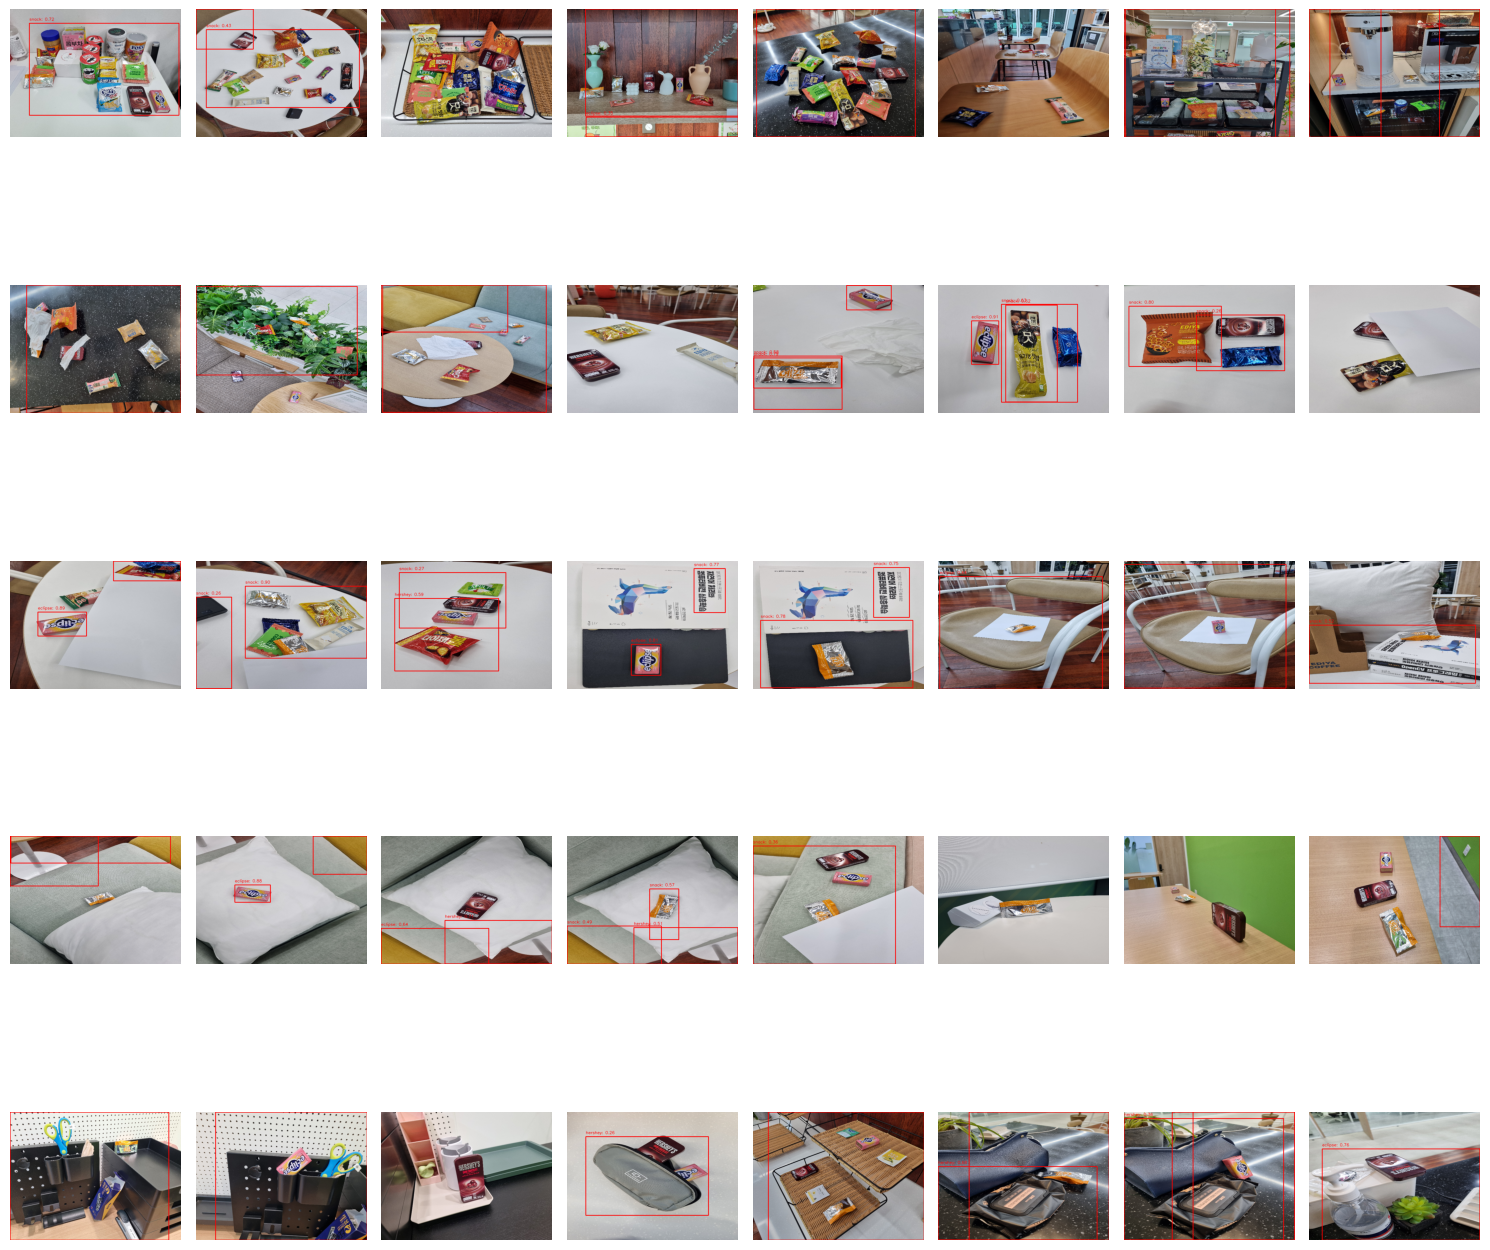

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. 학습된 YOLO 모델 가져오기
model = YOLO("runs/detect/1st_albu_reo_4_m_16602/weights/best.pt")

# 2. 클래스 이름 리스트 정의
class_name = ['snack', 'hershey', 'eclipse']

# 3. 테스트 파일 경로와 이미지 파일 목록 가져오기
folder_path = 'test_snack_detect'
files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 4. 처리된 이미지를 저장할 리스트
processed_images = []

# 5. 각 이미지에 대해 예측하고 바운딩 박스를 그리기
for file in files:
    filepath = os.path.join(folder_path, file)
    image = cv2.imread(filepath)
    resized_image = cv2.resize(image, (640, 480))  # 이미지 크기 조정

    # 모델 예측 수행
    results = model(resized_image)

    # 예측 결과에 따라 바운딩 박스와 텍스트 추가
    for result in results:
        for box in result.boxes:
            # 바운딩 박스 좌표 추출 및 정수 변환
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])

            # 레이블과 신뢰도 점수 추출
            confidence = box.conf.item()
            label = int(box.cls.item())
            label_name = class_name[label]

            # OpenCV로 바운딩 박스와 텍스트 추가
            cv2.rectangle(resized_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            text = f'{label_name}: {confidence:.2f}'
            cv2.putText(resized_image, text, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

    # RGB로 변환 후 리스트에 추가
    processed_images.append(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

# 6. 여러 이미지를 n행 × n열로 시각화하는 함수 정의
def plot_grid(images, rows, cols):
    """이미지를 n행 × n열 그리드로 표시"""
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # 그리드 생성

    for i, (img, ax) in enumerate(zip(images, axes.flatten())):
        ax.imshow(img)  # 이미지 표시
        ax.axis('off')  # 축 숨기기

    plt.tight_layout()  # 여백 정리
    plt.show()

# 7. 2x2 그리드로 이미지 시각화 (필요에 따라 변경 가능)
plot_grid(processed_images, rows=5, cols=8)
